# Imports

In [1]:
import torch
from pathlib import Path
from matplotlib import pyplot as plt
import numpy as np

In [2]:
from einops import rearrange, reduce

In [3]:
from torch.distributions import kl_divergence
from torch.distributions.normal import Normal


In [4]:
import torch
from pathlib import Path
from matplotlib import pyplot as plt
import numpy as np

from einops import rearrange, reduce

from torch.distributions import kl_divergence
from torch.distributions.normal import Normal
import torch

from vae import test_nll_estimation, parse_arguments

from pathlib import Path

# Functions

In [5]:
def load_stat(saved_stats_folder):
    order_fn = lambda p: int(str(p).split('_')[-1].split(".")[0])

    means_paths = sorted(list(Path(saved_stats_folder).glob("*.means")), key=order_fn)
    stds_paths = sorted(list(Path(saved_stats_folder).glob("*.stds")), key=order_fn)
    
    means = [torch.load(mean_path, map_location=torch.device('cpu')) for mean_path in means_paths]
    means_means = [mean['running_mean'] for mean in means]
    means_vars = [mean['running_var'] for mean in means]
    
    stds = [torch.load(std_path, map_location=torch.device('cpu')) for std_path in stds_paths]
    stds_means = [std['running_mean'] for std in stds]
    stds_vars = [std['running_var'] for std in stds]
    
    return [torch.stack(i) for i in [means_means, means_vars, stds_means, stds_vars]]    

In [16]:
args = dict(
    data_path='../Data/Dataset',
    device='cuda' if torch.cuda.is_available() else 'cpu',
    embedding_size=300,
    hidden_size=256,
    latent_size=16,
    num_layers=1,
    word_dropout=1.0,
    freebits=None,
    model_save_path='models',
    batch_size_valid=64,
    num_samples=10,
)

In [17]:
def get_approx_nlls(saved_model_files):
    nlls = []
    kls = []
    ppls = []
    for saved_model_file in saved_model_files:
        nll, kl, ppl = test_nll_estimation(saved_model_file=saved_model_file, **args)
        nlls.append(nll)
        kls.append(kl)
        ppls.append(ppl)
    return nlls, kls, ppls

In [18]:
def get_model_filenames(experiment_name='vanilla'):
    saved_model_files = [next(Path(f"results_final/results{i}/{experiment_name}/models/").iterdir()) for i in range(4)]
    saved_model_files = [str(f) for f in saved_model_files]
    return saved_model_files

# Result: Sample sentences

In [6]:
from sample_sentences import sample_sentence

In [7]:
from vae import Encoder, Sampler, WordDropout, Decoder, Lagrangian, SentenceVAE, evaluate

from pathlib import Path

import torch
from torch import nn
from torch.utils.data import DataLoader

from data import padded_collate, get_datasets


In [29]:
data_path = args['data_path']
train_data, val_data, test_data = get_datasets(data_path)
tokenizer = train_data.tokenizer

print("Lengths: ", len(train_data), len(val_data), len(test_data))

test_loader = DataLoader(
    val_data, batch_size=32, shuffle=False, collate_fn=padded_collate
)

model = SentenceVAE(
    vocab_size=tokenizer.vocab_size,
    embedding_size=300,
    hidden_size=256,
    latent_size=16,
    num_layers=1, #1,
    word_dropout_probability=1.0,
    unk_token_idx=tokenizer.unk_token_id,
    freebits = 0, # Freebits value is the lambda value as described in Kingma et al. 
)

Lengths:  39832 1700 2416


In [30]:
experiments = [
    "vanilla",
    "word_dropout_066",
    "freebits_05",
    "mdr10",
    "word_dropout_066_freebits_05",
    "word_dropout_066_mdr_10",
]

In [31]:
models0 = [get_model_filenames(experiment)[0] for experiment in experiments]
models0

['results_final/results0/vanilla/models/sentence_vae_3500.pt',
 'results_final/results0/word_dropout_066/models/sentence_vae_6000.pt',
 'results_final/results0/freebits_05/models/sentence_vae_FreeBits_0.5_3500.pt',
 'results_final/results0/mdr10/models/sentence_vae_MDR_10.0_3500.pt',
 'results_final/results0/word_dropout_066_freebits_05/models/sentence_vae_FreeBits_0.5_4500.pt',
 'results_final/results0/word_dropout_066_mdr_10/models/sentence_vae_MDR_10.0_6000.pt']

In [33]:
for experiment, model_filename in zip(experiments, models0):
    model.load_from(model_filename)
    print(f"\n\n{experiment} sample sentences:\n")
    for i in range(5):
        sentence = sample_sentence(model, tokenizer, number=2)



vanilla sample sentences:

`` The company is a lot of about $ 30 million , '' said Mr. Mehl , who had been a vice president of the company 's board [EOS]
The company said it expects to be a loss of $ 2.3 million , or $ 1.19 a share , in the first quarter [EOS]
The company said it expects to be a loss of $ 2.3 million , or $ 1.19 a share , a year earlier [EOS]
In the past decade , the company said it will be a dividend to $ 50 million from $ 1 million [EOS]
The company said it expects to be a loss of $ 7 million , or $ 1.19 a share , in the first quarter [EOS]


word_dropout_066 sample sentences:

But the company said it would n't identify the company 's new product [EOS]
But the company said it would n't identify the U.S. and other objectives [EOS]
The company said it will be a `` crisper '' for the company 's new product [EOS]
`` It 's a wait-and-see situation , '' says Mr. Verwoerd [EOS]
`` The market is a lot of the market , '' says Mr. Verwoerd , a former vice president [EOS]


f

# Tracked values results

In [92]:
folder_vanilla = "results_final/results0/vanilla/checkpoints"

folder_mdr = "results_final/results0/mdr10/checkpoints"

folder_freebits = "results_final/results0/freebits_05/checkpoints"

In [95]:
prior = Normal(0.0, 1.0)

In [97]:
names = ['vanilla', 'mdr', 'freebits']
folders = [folder_vanilla, folder_mdr, folder_freebits]

In [98]:
stats = [load_stat(folder) for folder in folders]  # means_means, means_vars, stds_means, stds_vars

In [99]:
qs = [Normal(means_means, torch.sqrt(vars_means)) for means_means, _, vars_means, _ in stats]

In [100]:
kls = [kl_divergence(q, prior) for q in qs]

In [101]:
vmin = min([t.min() for t in kls])
vmax = max([t.max() for t in kls])

In [102]:
vmin, vmax

(tensor(1.3117e-06), tensor(0.2340))

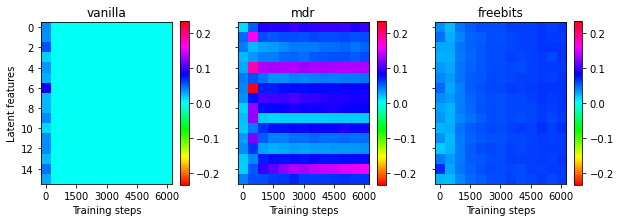

In [103]:
f, axes = plt.subplots(1, len(kls), figsize=(10, 3), sharex=True, sharey=True)
first = True
for ax, kl, name in zip(axes, kls, names):
    if first:
        ax.set_ylabel('Latent features')
        first = False
#     pcm = ax.imshow(kl.T, vmin=vmin, vmax=vmax, cmap='hsv')
    pcm = ax.imshow(kl.T, vmin=-vmax, vmax=vmax, cmap='hsv')
#     pcm = ax.imshow(kl.T)
    f.colorbar(pcm, ax=ax)
    ax.set_xlabel('Training steps')
    ax.set_title(name)
    ticks = np.arange(0, kl.shape[0], 3)
    ax.set_xticks(ticks)
    ax.set_xticklabels(ticks * 500)


plt.savefig('KL.eps', bbox_inches='tight')
plt.show()

# Test Results

In [74]:
num_samples = 10

## Vanilla

In [8]:
saved_model_files = get_model_filenames('vanilla')
saved_model_files

['results_final/results0/vanilla/models/sentence_vae_3500.pt',
 'results_final/results1/vanilla/models/sentence_vae_3500.pt',
 'results_final/results2/vanilla/models/sentence_vae_3500.pt',
 'results_final/results3/vanilla/models/sentence_vae_3500.pt']

In [ ]:
vanilla_nlls, vanilla_kls, vanilla_ppls = get_approx_nlls(saved_model_files)

## Word dropout

In [11]:
saved_model_files = get_model_filenames('word_dropout_066')
saved_model_files

['results_final/results0/word_dropout_066/models/sentence_vae_6000.pt',
 'results_final/results1/word_dropout_066/models/sentence_vae_4500.pt',
 'results_final/results2/word_dropout_066/models/sentence_vae_6000.pt',
 'results_final/results3/word_dropout_066/models/sentence_vae_6000.pt']

In [ ]:
wd_nlls, wd_kls, wd_ppls = get_approx_nlls(saved_model_files)

In [13]:
print(wd_nlls)

[tensor(126.3573, device='cuda:0'), tensor(127.2923, device='cuda:0'), tensor(126.4816, device='cuda:0'), tensor(126.8953, device='cuda:0')]


## Free Bits

In [14]:
saved_model_files = get_model_filenames('freebits_05')
saved_model_files

['results_final/results0/freebits_05/models/sentence_vae_FreeBits_0.5_3500.pt',
 'results_final/results1/freebits_05/models/sentence_vae_FreeBits_0.5_3500.pt',
 'results_final/results2/freebits_05/models/sentence_vae_FreeBits_0.5_3500.pt',
 'results_final/results3/freebits_05/models/sentence_vae_FreeBits_0.5_3500.pt']

In [ ]:
fb_nlls, fb_kls, fb_ppls = get_approx_nlls(saved_model_files)

In [16]:
print(fb_nlls)

[tensor(121.0335, device='cuda:0'), tensor(120.8254, device='cuda:0'), tensor(120.9688, device='cuda:0'), tensor(121.1455, device='cuda:0')]


## MDR

In [17]:
saved_model_files = get_model_filenames('mdr10')
saved_model_files

['results_final/results0/mdr10/models/sentence_vae_MDR_10.0_3500.pt',
 'results_final/results1/mdr10/models/sentence_vae_MDR_10.0_3500.pt',
 'results_final/results2/mdr10/models/sentence_vae_MDR_10.0_3500.pt',
 'results_final/results3/mdr10/models/sentence_vae_MDR_10.0_3500.pt']

In [ ]:
mdr_nlls, mdr_kls, mdr_ppls = get_approx_nlls(saved_model_files)

In [19]:
print(mdr_nlls)

[tensor(119.7502, device='cuda:0'), tensor(119.9091, device='cuda:0'), tensor(120.0708, device='cuda:0'), tensor(119.5433, device='cuda:0')]


## Word dropout & Free Bits

In [20]:
saved_model_files = get_model_filenames('word_dropout_066_freebits_05')
saved_model_files

['results_final/results0/word_dropout_066_freebits_05/models/sentence_vae_FreeBits_0.5_4500.pt',
 'results_final/results1/word_dropout_066_freebits_05/models/sentence_vae_FreeBits_0.5_6000.pt',
 'results_final/results2/word_dropout_066_freebits_05/models/sentence_vae_FreeBits_0.5_6000.pt',
 'results_final/results3/word_dropout_066_freebits_05/models/sentence_vae_FreeBits_0.5_7000.pt']

In [ ]:
wd_fb_nlls, wd_fb_kls, wd_fb_ppls = get_approx_nlls(saved_model_files)

In [22]:
print(wd_fb_nlls)

[tensor(121.7844, device='cuda:0'), tensor(121.3049, device='cuda:0'), tensor(121.2192, device='cuda:0'), tensor(121.9081, device='cuda:0')]


## Word dropout & MDR

In [23]:
saved_model_files = get_model_filenames('word_dropout_066_mdr_10')
saved_model_files

['results_final/results0/word_dropout_066_mdr_10/models/sentence_vae_MDR_10.0_6000.pt',
 'results_final/results1/word_dropout_066_mdr_10/models/sentence_vae_MDR_10.0_6000.pt',
 'results_final/results2/word_dropout_066_mdr_10/models/sentence_vae_MDR_10.0_6000.pt',
 'results_final/results3/word_dropout_066_mdr_10/models/sentence_vae_MDR_10.0_4500.pt']

In [ ]:
wd_mdr_nlls, wd_mdr_kls, wd_mdr_ppls = get_approx_nlls(saved_model_files)

In [25]:
print(vanilla_nlls, vanilla_kls)

[tensor(126.9942, device='cuda:0'), tensor(127.1339, device='cuda:0'), tensor(127.0793, device='cuda:0'), tensor(126.7280, device='cuda:0')] [tensor(0.0486, device='cuda:0'), tensor(0.0453, device='cuda:0'), tensor(0.0573, device='cuda:0'), tensor(0.0670, device='cuda:0')]


In [26]:
print(wd_nlls, wd_kls)

[tensor(126.3573, device='cuda:0'), tensor(127.2923, device='cuda:0'), tensor(126.4816, device='cuda:0'), tensor(126.8953, device='cuda:0')] [tensor(1.2080, device='cuda:0'), tensor(1.0724, device='cuda:0'), tensor(1.4329, device='cuda:0'), tensor(1.1597, device='cuda:0')]


In [27]:
print(fb_nlls, fb_kls)

[tensor(121.0335, device='cuda:0'), tensor(120.8254, device='cuda:0'), tensor(120.9688, device='cuda:0'), tensor(121.1455, device='cuda:0')] [tensor(8.1792, device='cuda:0'), tensor(8.3366, device='cuda:0'), tensor(8.2716, device='cuda:0'), tensor(8.2359, device='cuda:0')]


In [28]:
print(mdr_nlls, mdr_kls)

[tensor(119.7502, device='cuda:0'), tensor(119.9091, device='cuda:0'), tensor(120.0708, device='cuda:0'), tensor(119.5433, device='cuda:0')] [tensor(9.7394, device='cuda:0'), tensor(9.5362, device='cuda:0'), tensor(9.7923, device='cuda:0'), tensor(9.5691, device='cuda:0')]


In [29]:
print(wd_fb_nlls, wd_fb_kls)

[tensor(121.7844, device='cuda:0'), tensor(121.3049, device='cuda:0'), tensor(121.2192, device='cuda:0'), tensor(121.9081, device='cuda:0')] [tensor(8.4971, device='cuda:0'), tensor(8.7278, device='cuda:0'), tensor(8.8820, device='cuda:0'), tensor(9.1538, device='cuda:0')]


In [30]:
print(wd_mdr_nlls, wd_mdr_kls)

[tensor(120.9624, device='cuda:0'), tensor(121.1598, device='cuda:0'), tensor(120.4921, device='cuda:0'), tensor(121.6460, device='cuda:0')] [tensor(8.9841, device='cuda:0'), tensor(9.4737, device='cuda:0'), tensor(9.8161, device='cuda:0'), tensor(9.1793, device='cuda:0')]


## Summary of Results

### NLL

In [54]:
all_results = {
    "Vanilla": torch.tensor(vanilla_nlls),
    "Word dropout": torch.tensor(wd_nlls),
    "Free Bits": torch.tensor(fb_nlls),
    "MDR": torch.tensor(mdr_nlls),
    "Word dropout & Free Bits": torch.tensor(wd_fb_nlls),
    "Word dropout & MDR": torch.tensor(wd_mdr_nlls),
}

In [57]:
print("NLL:")
for name, res in all_results.items():
    std, mean = torch.std_mean(res)
    print(f"{name: >24}: \t {mean:.4f} \t ({std:.4f})")

NLL:
                 Vanilla: 	 126.9838 	 (0.1800)
            Word dropout: 	 126.7566 	 (0.4248)
               Free Bits: 	 120.9933 	 (0.1336)
                     MDR: 	 119.8184 	 (0.2253)
Word dropout & Free Bits: 	 121.5541 	 (0.3428)
      Word dropout & MDR: 	 121.0651 	 (0.4779)


### KL

In [58]:
all_results = {
    "Vanilla": torch.tensor(vanilla_kls),
    "Word dropout": torch.tensor(wd_kls),
    "Free Bits": torch.tensor(fb_kls),
    "MDR": torch.tensor(mdr_kls),
    "Word dropout & Free Bits": torch.tensor(wd_fb_kls),
    "Word dropout & MDR": torch.tensor(wd_mdr_kls),
}

In [59]:
print("KL:")
for name, res in all_results.items():
    std, mean = torch.std_mean(res)
    print(f"{name: >24}: \t {mean:.4f} \t ({std:.4f})")

KL:
                 Vanilla: 	 0.0545 	 (0.0097)
            Word dropout: 	 1.2182 	 (0.1537)
               Free Bits: 	 8.2558 	 (0.0659)
                     MDR: 	 9.6593 	 (0.1257)
Word dropout & Free Bits: 	 8.8152 	 (0.2756)
      Word dropout & MDR: 	 9.3633 	 (0.3628)


## Perplexity

In [60]:
all_results = {
    "Vanilla": torch.tensor(vanilla_ppls),
    "Word dropout": torch.tensor(wd_ppls),
    "Free Bits": torch.tensor(fb_ppls),
    "MDR": torch.tensor(mdr_ppls),
    "Word dropout & Free Bits": torch.tensor(wd_fb_ppls),
    "Word dropout & MDR": torch.tensor(wd_mdr_ppls),
}

In [61]:
print("PPL:")
for name, res in all_results.items():
    std, mean = torch.std_mean(res)
    print(f"{name: >24}: \t {mean:.4f} \t ({std:.4f})")

PPL:
                 Vanilla: 	 224.3221 	 (1.6686)
            Word dropout: 	 230.8136 	 (3.2878)
               Free Bits: 	 230.0741 	 (1.2508)
                     MDR: 	 231.1117 	 (2.8169)
Word dropout & Free Bits: 	 238.7130 	 (3.8080)
      Word dropout & MDR: 	 239.1234 	 (4.4025)
